In [24]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# %matplotlib inline

# sns.set(palette="magma_r")

In [32]:
def load_ref_colors(xlsx, refcolor_sheet):
    print("\n Loading Reference Colors ...")
    color_ref = xlsx.parse(refcolor_sheet)
    color_array = color_ref["colorname0"].unique()
    print(color_array[:5])
    return color_array

In [33]:
def load_categories(xlsx, category_sheet):
    print("\n Loading Category data ...")
    df_cat = xlsx.parse(category_sheet)
    df_cat.dropna(inplace=True)
    df_cat["Category ID"] = df_cat["Category ID"].astype("int32")
    df_cat= df_cat[["Category ID","Category Name"]]
    print(df_cat.sample(5))
    return df_cat

In [34]:
def map_category(x):
    corrections = {
                    "Boots": "Boots & Booties",
                    "T-shirts":"T Shirts", 
                    "Sports Bras":"Bras",
                    "Denim": "Jeans"
                  }    
    x = x.split(":")[0].strip()
    mapped = corrections.get(x,0)
    if corrections.get(x,0) != 0:
        x = corrections.get(x,0)
    return x

def load_occasion_data(xlsx, occassion_sheet, catagory_df):

    print("\n Loading Occasion data ...")
    df_occassion = xlsx.parse(occassion_sheet, header=None, usecols=0)
    df_occassion.columns=["category"]
    
    """Remove lines with only category name and no occasion mapping and blank lines""" 
    df_occassion["category"] = df_occassion[df_occassion["category"].map(lambda x : ":" in x)]
    df_occassion.dropna(inplace=True)
    
    """Ensure category is one of the categories in Category-subcategory list""" 
    df_occassion["temp"] = df_occassion["category"].apply(lambda x : " ".join([i.strip() for i in x.split(":")[1].strip().split(",")] ))
    df_occassion["category"] = df_occassion["category"].apply(lambda x : map_category(x))
    df_occassion["category"] = df_occassion["category"]

    """Create one row per occasion"""
    df_occassion = df_occassion.join(
        df_occassion.temp.str.split(expand=True).stack().reset_index(drop=True, level=1)
        .rename("occassion")).drop("temp",axis=1)

    df_occassion=pd.merge(df_occassion, catagory_df, left_on="category", right_on="Category Name", how="left").\
        drop("Category Name", axis=1).rename(columns = {"Category ID": "category_id"})

    """Categories "Sweaters", "Sweatshirt" and Suits will be dropped as there are no matching Category ID's"""
    df_occassion.dropna(inplace=True)
    df_occassion["category_id"] = df_occassion["category_id"].astype("int32")
    print(df_occassion.sample(5))
    return df_occassion
    



In [38]:
def load_brands(xlsx,brands_sheet):
    print("\n Loading Brands data ...")
    df_topbrands = xlsx.parse(brands_sheet)
    df_topbrands = df_topbrands["brand_name"].append(df_topbrands["brand_name_synonym"]).map(lambda x : "".join(x.split()).lower()).drop_duplicates().sort_values().reset_index(drop=True)
    print(df_topbrands.sample(5))
    return df_topbrands

In [41]:
def load_influencers(xlsx,influencer_sheet):

    print("\n Loading Influencer data ...")

    """ List of influencers to look for as """
    ''' hardcoded as influencers are mixed together as one long string in the data witout seperators'''
    influencers = [
        "ariellecharnas",
        "blaireadiebee",
        "blakevond",
        "chiaraferragni",
        "hannahbronfman",
        "jordynwoods",
        "manrepeller",
        "mayemusk",
        "nicolettemason",
        "seaofshoes",
        "somethingnavy",
        "weworewhat"
    ]

    df_influencers = xlsx.parse(influencer_sheet)
    df_influencers["user_id"] = df_influencers["user_id"].map(lambda x : x[-13:])
    df_influencers["influencers"] = df_influencers["style_who_inspiries"].map(lambda x : [1 if re.search(i,x) else 0 for i in influencers ])
    df_influencers[influencers] = pd.DataFrame(df_influencers["influencers"].values.tolist(), index = df_influencers.index)
    df_influencers.drop(["style_who_inspiries", "influencers"], axis =1, inplace=True)
    df_influencers.fillna(0,inplace=True)
    print(df_influencers.sample(5))
    return df_influencers
    

In [44]:
# excel_data = pd.ExcelFile('../../data/raw/mar19.xlsx')
# print("Sheet Names in the input XLSX:\n",xlsx.sheet_names)

"""Variables to avoid hardcoding of sheet names which might change later"""
top_brands_sheet = "1. top_100_brands(brandname+syn"
category_sheet = "9. category_ids"
user_sheet = "14. 100_users_set"
items_sheet = "15. 100_users_item_set"
wishlist_sheet = "12. wishlist_items"
influencer_sheet = "16. 100_user_influencer"
refcolor_sheet = "2. reference_color"
occassion_sheet = '6. category_and_subcategory'


color_array = load_ref_colors(excel_data, refcolor_sheet)
df_category = load_categories(excel_data, category_sheet)
df_occassion = load_occasion_data(excel_data, occassion_sheet, df_category)
df_topbrands = load_brands(excel_data, top_brands_sheet)
df_influencers = load_influencers(excel_data,influencer_sheet)
# excel_data = None


 Loading Reference Colors ...
['white' 'aliceblue' 'antiquewhite' 'aquamarine' 'azure']

 Loading Category data ...
    Category ID Category Name
15          142          Work
56          350         Totes
65          470         Other
70          520         Nails
32          162          Bras

 Loading Occasion data ...
      category occassion  category_id
110      Pants      Life          123
91      Skirts      Life          121
258  Outerwear   Errands          164
236       Tops   Workout          110
252   Sneakers    Movies          250

 Loading Brands data ...
119        vincecamuto
111    urbanoutfitters
75     newyork&company
23          clubmonaco
16               bhldn
dtype: object

 Loading Influencer data ...
          user_id  ariellecharnas  blaireadiebee  blakevond  chiaraferragni  \
14  1527986118007               0              0          0               0   
49  1535981637224               0              0          0               0   
13  1532487913121        

# User data EDA

In [11]:
df_users = xlsx.parse(user_sheet)

user_fields = [
    "user_id",
    "style_age_range",
    "style_age_range_group",
    "items_in_wishlist",
    "style_brands_selected",
    "style_size_preference_none",
    "style_size_preference_petite",
    "style_size_preference_extra_long",
    "style_size_preference_plus",
    "style_size_preference_maternity",
    "style_size_preference_skipped",
    "style_vibe",
    "has_stype_vibe",
    "style_who_inspiries_skipped",
    "style_looks_wanted_dates",
    "style_looks_wanted_everyday",
    "style_looks_wanted_formal",
    "style_looks_wanted_nights",
    "style_looks_wanted_other",
    "style_looks_wanted_summer",
    "style_looks_wanted_travel",
    'style_looks_wanted_winter',
    "style_looks_wanted_work",
    "style_looks_wanted_workouts",
    "style_looks_wanted_skipped",
    'style_most_important_active', 
    'style_most_important_any',
    'style_most_important_beach', 
    'style_most_important_dress',
    'style_most_important_bags', 
    'style_most_important_jeans',
    'style_most_important_jump', 
    'style_most_important_nothing',
    'style_most_important_outwear', 
    'style_most_important_pants',
    'style_most_important_shoes', 
    'style_most_important_tops',
    'style_most_important_skipped'
    ]


user_fillna_zero_columns = [
    "style_size_preference_none",
    "style_size_preference_petite",
    "style_size_preference_extra_long",
    "style_size_preference_plus",
    "style_size_preference_maternity",
    "style_looks_wanted_dates",
    "style_looks_wanted_everyday",
    "style_looks_wanted_formal",
    "style_looks_wanted_nights",
    "style_looks_wanted_other",
    "style_looks_wanted_summer",
    "style_looks_wanted_travel",
    'style_looks_wanted_winter',
    "style_looks_wanted_work",
    "style_looks_wanted_workouts",
    'style_most_important_active', 
    'style_most_important_any',
    'style_most_important_beach', 
    'style_most_important_dress',
    'style_most_important_bags', 
    'style_most_important_jeans',
    'style_most_important_jump', 
    'style_most_important_nothing',
    'style_most_important_outwear', 
    'style_most_important_pants',
    'style_most_important_shoes', 
    'style_most_important_tops',
    'style_most_important_skipped'
]

user_drop_columns = [
    "style_age_range",
    "style_brands_selected",
    "has_stype_vibe",
    "style_who_inspiries_skipped",
    "items_in_wishlist"
]

user_int_conversion_columns = [
    "style_age_range_group",
    "style_size_preference_none",
    "style_size_preference_petite",
    "style_size_preference_extra_long",
    "style_size_preference_plus",
    "style_size_preference_maternity",
    "style_size_preference_skipped",
    "style_looks_wanted_dates",
    "style_looks_wanted_everyday",
    "style_looks_wanted_formal",
    "style_looks_wanted_nights",
    "style_looks_wanted_other",
    "style_looks_wanted_summer",
    "style_looks_wanted_travel",
    'style_looks_wanted_winter',
    "style_looks_wanted_work",
    "style_looks_wanted_workouts",
    "style_looks_wanted_skipped",
    'style_most_important_active', 
    'style_most_important_any',
    'style_most_important_beach', 
    'style_most_important_dress',
    'style_most_important_bags', 
    'style_most_important_jeans',
    'style_most_important_jump', 
    'style_most_important_nothing',
    'style_most_important_outwear', 
    'style_most_important_pants',
    'style_most_important_shoes', 
    'style_most_important_tops',
    'style_most_important_skipped'
]

"""
placeholder to impute style looks wanted columns
for now drop the columns
"""
style_looks_columns = [
    "style_looks_wanted_dates",
    "style_looks_wanted_everyday",
    "style_looks_wanted_formal",
    "style_looks_wanted_nights",
    "style_looks_wanted_other",
    "style_looks_wanted_summer",
    "style_looks_wanted_travel",
    'style_looks_wanted_winter',
    "style_looks_wanted_work",
    "style_looks_wanted_workouts",
] 

df_users = df_users[user_fields]
df_users["user_id"] = df_users["user_id"].map(lambda x : x[-13:])
df_users["style_age_range_group"] = df_users["style_age_range_group"].fillna(5)
df_users["style_vibe"] = df_users["style_vibe"].fillna("None")


df_users[user_fillna_zero_columns] = df_users[user_fillna_zero_columns].fillna(0)


df_users.drop(user_drop_columns, axis=1, inplace=True)


df_users[user_int_conversion_columns] = df_users[user_int_conversion_columns].astype("int64")


df_users = pd.merge(df_users,df_influencers,left_on="user_id",right_on="user_id", how="left")
df_users[influencers] = df_users[influencers].fillna(0).astype("int64")
df_users.duplicated(df_users.columns[1:]).sum()
df_users.drop("style_vibe", inplace=True, axis =1)
df_users.drop(style_looks_columns, axis=1, inplace=True)
df_users.sample(5)

,user_id,style_age_range_group,style_size_preference_none,style_size_preference_petite,style_size_preference_extra_long,style_size_preference_plus,style_size_preference_maternity,style_size_preference_skipped,style_vibe,style_looks_wanted_dates,style_looks_wanted_everyday,style_looks_wanted_formal,style_looks_wanted_nights,style_looks_wanted_other,style_looks_wanted_summer,style_looks_wanted_travel,style_looks_wanted_winter,style_looks_wanted_work,style_looks_wanted_workouts,style_looks_wanted_skipped,style_most_important_active,style_most_important_any,style_most_important_beach,style_most_important_dress,style_most_important_bags,style_most_important_jeans,style_most_important_jump,style_most_important_nothing,style_most_important_outwear,style_most_important_pants,style_most_important_shoes,style_most_important_tops,style_most_important_skipped,ariellecharnas,blaireadiebee,blakevond,chiaraferragni,hannahbronfman,jordynwoods,manrepeller,mayemusk,nicolettemason,seaofshoes,somethingnavy,weworewhat
43,1526451666138,5,0,0,0,0,0,1,None,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
87,1549834228578,1,0,0,0,0,0,0,Windsor,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
110,1490404459978,5,0,0,0,0,0,1,None,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
59,1536423200884,1,0,0,0,0,0,0,Oshawa,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,1,0
42,1540519065537,1,0,0,0,0,0,0,West Caldwell,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0


In [12]:
""" This is a concern to be addressed """



25

# EDA for Item Data

In [17]:
item_columns_tokeep = [
        'user_id', 'brand_id', 'user_provided_brand_name', 'parsed_brand_name',
        'store_id', 'user_provided_store_name','parsed_store_name','product_id', 
        'item_name_lower', 'product_category_id', 'paid_price',
        'list_price', 'sale_price',
        'order_total_amt', 'size', 'email_dt', 'color_parsed']

""" usecols not working. Seems to be a bug"""
df_items = xlsx.parse(items_sheet)
df_items = df_items[item_columns_tokeep]


df_items["user_id"] = df_items["user_id"].map(lambda x : x[-13:])

##Dropping rows with null product ID
df_items = df_items[~df_items["product_id"].isnull()]
df_items["product_id"] = df_items["product_id"].map(lambda x : x[-8:])


df_items["product_category_id"].fillna(0, inplace=True)
df_items["product_category_id"] = df_items["product_category_id"].astype("int64")


##Adding "on sale" column indicate a purchase of item in sale 
df_items["on_sale"] = df_items["sale_price"].map(lambda x : True if x > 0 else False)
df_items["part_of_order"] = df_items.apply(lambda x : True if x["order_total_amt"] > x["paid_price"] else False, axis=1)

##Get brand id with blank from other two brand columns when avaialble, else set to None
df_items["brand_id"] = df_items["brand_id"].fillna(df_items["parsed_brand_name"])
df_items["brand_id"] = df_items["brand_id"].fillna(df_items["user_provided_brand_name"])
condition = pd.notnull(df_items["brand_id"])
df_items.loc[condition,"brand_id"] = df_items.loc[condition,"brand_id"].map(lambda x : "".join(x.split()).lower())

df_items["brand_id"].fillna("None", inplace=True)

##Get store id with blank from other two brand columns when avaialble, else set to None
df_items["store_id"] = df_items["store_id"].fillna(df_items["parsed_store_name"])
df_items["store_id"] = df_items["store_id"].fillna(df_items["user_provided_store_name"])
condition = pd.notnull(df_items["brand_id"])
df_items.loc[condition,"store_id"] = df_items.loc[condition,"store_id"].map(lambda x : "".join(x.split()).lower())

##Set store id ro Brand ID when null
# condition = pd.isnull(df_items["store_id"])
# df_items.loc[condition,"store_id"] = df_items.loc[condition,"brand_id"]

df_items["store_id"] = df_items["store_id"].fillna(df_items["brand_id"])

## Set store ID to none if still not available
df_items["store_id"].fillna("None", inplace=True)
df_items["top_brand"] = df_items["store_id"].map(lambda x : True if x in df_topbrands.values.tolist() else False )



df_items["item_name_lower"] = df_items["item_name_lower"].fillna("None")
df_items["item_name_lower"] = df_items["item_name_lower"].map(lambda x : str(x).lower())

df_items["color_parsed"] = df_items["color_parsed"].fillna("None")
df_items["color_parsed"] = df_items["color_parsed"].map(lambda x : str(x).lower())

# df_items["item_name_lower"] = df_items["item_name_lower"].fillna("None")
# df_items["color_parsed"] = df_items["color_parsed"].fillna("None")
# df_items["color_parsed"] = df_items["color_parsed"].str.lower()

color_parse_lst = [set(str(e)) for e in df_items["color_parsed"].str.split()]
df_items["color"] = [e&set(df_color) for e in color_parse_lst]
df_items["color"] = [list(e)[0] if len(list(e))!=0 else "" for e in df_items["color"]]


color_ntlst = [set(e) for e in df_items["item_name_lower"].str.split()]
df_items["color_tmp1"] = [e&set(df_color) for e in color_ntlst]
df_items["color_tmp1"] = [list(e)[0] if len(list(e))!=0 else "" for e in df_items["color_tmp1"]]

df_items["color"] = df_items["color"].replace('', df_items["color_tmp1"])

item_drop_columns = [
    "sale_price",
    "order_total_amt",
    "user_provided_brand_name",
    "parsed_brand_name",
    "user_provided_store_name",
    "parsed_store_name",
    "email_dt",
    "list_price",
    "color_tmp1",
    "color_parsed"
]
df_items.drop(item_drop_columns, axis = 1,inplace=True)

df_items.sample(5)


,user_id,brand_id,store_id,product_id,item_name_lower,product_category_id,paid_price,size,on_sale,part_of_order,top_brand,color
5885,1534459103461,forever21,forever21,60336342,stripe offtheshoulder crop top,161,14.31,MEDIUM,False,False,True,
3629,1529282181454,sebby,hautelook,50974057,faux fur notch collar jacket,152,69.97,NaN,False,False,False,
4305,1537656557616,jcrew,jcrew,61696648,fulllength cameron pant in fourseason stretch,123,44.75,8,False,False,True,
6094,1539198476327,fashionnova,fashionnova,98701787,feelings in the air mini dress,141,17.49,S,False,False,True,
11784,1490404459978,None,nordstrom,2aec39fc,madewell kent stripe cardigan,114,110.00,Medium,False,False,False,


In [18]:
""" Seems like this part of order column can be dropped"""
df_items.part_of_order.value_counts()

False    13875
True       145
Name: part_of_order, dtype: int64

In [19]:
""" Leave on sale as is for now"""
df_items.on_sale.value_counts()

False    13431
True       589
Name: on_sale, dtype: int64

In [20]:
""" Category ID have lot of in correct values. Drop the rows with category ID that is not present in master list"""
df_items.product_category_id.value_counts()

0        1861
500      1736
600      1549
141      1030
111       909
610       897
112       506
114       487
410       380
124       341
113       305
160       295
171       279
123       272
210       224
240       215
163       195
122       188
121       179
155       172
152       159
230       156
540       129
220       120
320       116
550        92
250        81
430        74
510        67
440        61
151        58
125        55
131        55
132        52
172        51
153        51
350        51
420        50
144        46
530        40
161        38
310        35
154        35
460        29
200        29
560        27
561        24
562        24
19160      24
143        17
480        17
470        14
450        13
340        10
330        10
110         8
162         6
164         6
520         5
16238       5
10179       4
120         4
142         4
400         4
17074       4
16562       3
191         3
17908       3
22458       3
16867       2
202         2
170   

In [21]:
condition = df_items.product_category_id.map( lambda x : x in df_cat["Category ID"].values.tolist())
df_items = df_items[condition]

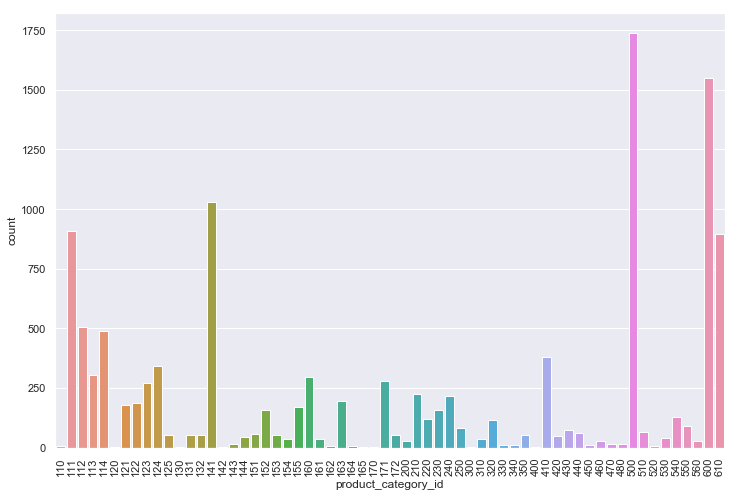

In [22]:
plt.figure(figsize=(12,8))
g = sns.countplot(df_items.product_category_id)
loc, labels = plt.xticks(rotation=90)

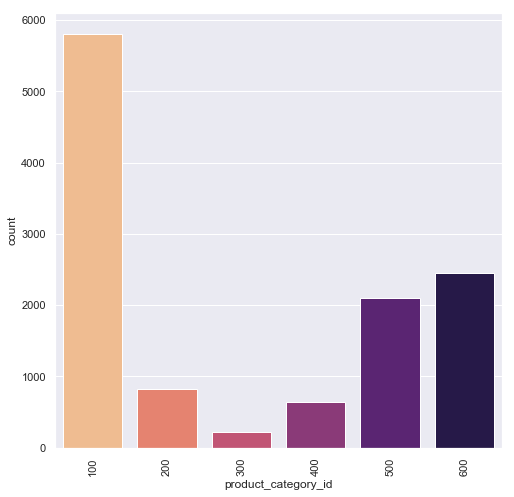

In [23]:
major_cats = (df_items.product_category_id//100)*100
plt.figure(figsize=(8,8))
g = sns.countplot(major_cats)
loc, labels = plt.xticks(rotation=90)

In [24]:
df_items.sample(8)

,user_id,brand_id,store_id,product_id,item_name_lower,product_category_id,paid_price,size,on_sale,part_of_order,top_brand,color
8897,1495121490933,None,sephora,09ab6f1d,josie maran 100 percent pure argan oil josie m...,500,0.00,NaN,False,False,True,
12761,1528340569558,forever21,forever21,8c673fb2,beaded chain choker,410,4.00,ONE SIZE,False,False,True,
1268,1517962134688,None,macys,2a288c3e,kate spade new york cameron street large lane ...,330,0.00,HANDBAG,False,False,False,
12783,1528340569558,zara,zara,34697ae8,midrise selvedge jeans,124,50.00,4,False,False,True,
5536,1533655416477,None,nordstrom,4433c3cc,treasure bond x something navy poplin sleeve s...,155,79.00,Large,False,False,False,navy
9186,1506291233259,None,sephora,0ca903f1,sunday riley luna sleeping night oil 1 oz 30 ml,500,105.00,NaN,False,False,True,
11825,1542061238350,nars,hautelook,37087111,night series eyeshadow flight,540,9.97,NaN,False,False,False,
536,1495117820151,leota,hautelook,6c670375,llana cap sleeve mini dress,141,55.00,NaN,False,False,False,


In [25]:
# wishlist_columns_tokeep = [
    
# ]
# df_wish = xlsx.parse(wishlist_sheet)
# df_wish["user_id"] = df_wish["userid"].map(lambda x : x[-13:])
# df_wish["product_id"] = df_wish["itemid"].map(lambda x : x[-8:])

# wish_drop_columns = [
#     "userid", "itemid"
# ]
# df_wish.drop(wish_drop_columns, axis=1, inplace=True)

# df_wish.head()

In [26]:
len(df_items.brand_id.unique())

744

In [27]:
df_items.store_id.unique()

array(['loft', 'zara', 'jcrewfactory', 'victoriassecret', 'oldnavy',
       'macys', 'ulta', 'sephora', 'nordstrom', 'dsw', 'jcrew',
       'lillypulitzer', 'anthropologie', 'lastcall', 'target',
       'baublebar', 'hautelook', '6pmcom', 'katespade', 'saksfifthavenue',
       'ebay', 'roadrunnersports', 'anntaylor', 'asos', 'americanapparel',
       'hm', 'revolve', 'guess', 'bananarepublic', 'lordtaylor',
       'intermix', 'draperjames', 'therealreal', 'lululemon',
       'urbanoutfitters', 'bluefly', 'jcpenney', 'tradesy',
       'modaoperandi', 'nike', 'reformation', 'forwardbyelysewalker',
       'renttherunway', 'gap', 'modcloth', 'markspencer', 'llbean',
       'boden', 'stelladot', 'alexandani', 'letote', 'trunkclub',
       'bloomingdales', 'lucy', 'selfridgesco', 'madewell', 'freepeople',
       'underarmour', 'zappos', 'hunterboots', 'tefreepeople',
       'necessaryclothing', 'kohls', 'americaneagleoutfitters',
       'stitchfix', 'footlocker', 'poshmark', 'venus', 'toms',

In [28]:
df_items.head()

,user_id,brand_id,store_id,product_id,item_name_lower,product_category_id,paid_price,size,on_sale,part_of_order,top_brand,color
0,1485369350003,loft,loft,62733a41,petite textured pencil pants in julie fit,123,80.0,NaN,False,False,True,
1,1485369350003,loft,loft,7ca9f965,blurred fairisle sweater,114,70.0,NaN,False,False,True,
3,1485369350003,loft,loft,6273435d,lou grey eyelash sweater,114,70.0,NaN,False,False,True,grey
4,1485369350003,loft,loft,62732b46,petite plaid pencil pants in julie fit,123,80.0,NaN,False,False,True,
5,1485369350003,loft,loft,627342fa,petite custom stretch trouser leg pants in jul...,123,80.0,NaN,False,False,True,


In [29]:
df_items.columns



Index(['user_id', 'brand_id', 'store_id', 'product_id', 'item_name_lower',
       'product_category_id', 'paid_price', 'size', 'on_sale', 'part_of_order',
       'top_brand', 'color'],
      dtype='object')

In [30]:
df_items.product_id.value_counts()[:30]

2a5292a9    15
90ee0923    14
2a81a23e     9
90865976     9
25435319     9
f620ff9a     8
2a25061e     8
2a4ec016     7
2ae5e49f     6
7ca9d19c     6
39843431     6
43547485     6
91057473     5
2a16d674     5
f82362b2     5
63036724     5
62921846     5
875078a2     5
34949190     5
9d77b442     5
2a649222     5
2a9f4271     5
2a9853e0     5
90866170     4
18861804     4
90873255     4
2a009ef7     4
2ae98bbf     4
2a36941a     4
2acab180     4
Name: product_id, dtype: int64

In [31]:
df_items = df_items.drop_duplicates()

In [32]:
df_items.product_id.value_counts()[:30]

25435319    9
90865976    9
f620ff9a    8
43547485    6
63036724    5
62921846    5
90ee0923    5
2a24fee4    4
20829997    4
2a649222    4
aef3ee18    4
6279138a    4
90866170    4
81289877    4
2a5292a9    4
18861804    4
d3f5eb4d    4
13726682    4
90873255    4
2949102d    4
67063025    4
80945337    4
34cbb0e2    3
29146a28    3
5beeb874    3
2a56579b    3
2ababc07    3
62965940    3
2a009ef7    3
72710286    3
Name: product_id, dtype: int64

In [33]:
df_items = df_items[df_items["product_category_id"] <500]

In [34]:
df_items.product_id.value_counts()[:30]

6279138a    4
2949102d    4
8c3b18fc    3
2acab180    3
2a56579b    3
5beeb874    3
2ababc07    3
62766cf6    3
2ac6de18    3
2a009ef7    3
2ab35afb    3
34cbb0e2    3
6fe25399    3
34239973    3
f30ce9ad    3
2a56dfc6    3
2af4b449    2
72907990    2
2ad5578d    2
627b0799    2
2aba6518    2
4f34fa3a    2
99417533    2
19d34779    2
96471894    2
22056078    2
98823230    2
d002d8e4    2
2ae632f2    2
2a6aefdc    2
Name: product_id, dtype: int64

In [35]:
len(df_items.user_id.unique())

93

In [36]:
df_items.paid_price.value_counts()

0.00      288
20.00     160
30.00     150
25.00     138
40.00     128
50.00     112
15.00     107
10.00      98
18.00      95
35.00      94
28.00      88
48.00      87
39.00      81
60.00      80
45.00      76
19.00      74
49.00      73
12.00      72
24.00      69
14.00      67
70.00      66
38.00      63
16.00      61
29.00      60
5.00       57
98.00      57
59.00      56
68.00      54
13.00      54
9.00       54
8.00       53
34.00      52
42.00      51
21.00      47
29.99      46
55.00      46
19.99      46
58.00      45
59.50      45
32.00      45
26.00      45
88.00      44
54.00      44
65.00      43
69.50      42
22.00      42
23.00      41
69.00      41
49.50      38
78.00      37
99.00      37
44.00      37
36.00      37
49.95      37
17.00      36
128.00     35
27.00      35
64.00      35
80.00      34
11.00      32
89.00      32
52.00      31
7.00       30
39.95      30
100.00     29
90.00      29
39.50      28
79.00      26
29.95      26
34.99      26
37.00      25
79.50 

In [37]:
df_items = pd.merge(df_items,df_cat, left_on="product_category_id", right_on="Category ID", how="left",)
df_items.product_category_id = df_items.apply(lambda x : str(x["product_category_id"]) + " - "+ str(x["Category Name"]), axis=1)

df_items.drop("Category ID", axis =1, inplace=True)

In [38]:
df_items.head()

,user_id,brand_id,store_id,product_id,item_name_lower,product_category_id,paid_price,size,on_sale,part_of_order,top_brand,color,Category Name
0,1485369350003,loft,loft,62733a41,petite textured pencil pants in julie fit,123 - Pants,80.0,NaN,False,False,True,,Pants
1,1485369350003,loft,loft,7ca9f965,blurred fairisle sweater,114 - Knits,70.0,NaN,False,False,True,,Knits
2,1485369350003,loft,loft,6273435d,lou grey eyelash sweater,114 - Knits,70.0,NaN,False,False,True,grey,Knits
3,1485369350003,loft,loft,62732b46,petite plaid pencil pants in julie fit,123 - Pants,80.0,NaN,False,False,True,,Pants
4,1485369350003,loft,loft,627342fa,petite custom stretch trouser leg pants in jul...,123 - Pants,80.0,NaN,False,False,True,,Pants


In [39]:
# bins = pd.IntervalIndex.from_tuples([(0, 20), (21, 50), (51, 100), (101, 200), (201,500), (501,1000), (1001, 20000)])


In [40]:
bins = np.array([0.0, 20.0, 50.0, 100.0, 200.0, 500.0, 1000.0, 20000.0])
df_items["price_bin"] = np.digitize(df_items["paid_price"], bins)

In [41]:
df_items.head()

,user_id,brand_id,store_id,product_id,item_name_lower,product_category_id,paid_price,size,on_sale,part_of_order,top_brand,color,Category Name,price_bin
0,1485369350003,loft,loft,62733a41,petite textured pencil pants in julie fit,123 - Pants,80.0,NaN,False,False,True,,Pants,3
1,1485369350003,loft,loft,7ca9f965,blurred fairisle sweater,114 - Knits,70.0,NaN,False,False,True,,Knits,3
2,1485369350003,loft,loft,6273435d,lou grey eyelash sweater,114 - Knits,70.0,NaN,False,False,True,grey,Knits,3
3,1485369350003,loft,loft,62732b46,petite plaid pencil pants in julie fit,123 - Pants,80.0,NaN,False,False,True,,Pants,3
4,1485369350003,loft,loft,627342fa,petite custom stretch trouser leg pants in jul...,123 - Pants,80.0,NaN,False,False,True,,Pants,3


In [42]:
## Write dataframe to CSV file
df_users.to_csv("../../data/processed/users.csv",index=False)
df_items.to_csv("../../data/processed/items.csv",index=False)
df_influencers.to_csv("../../data/processed/influencers.csv",index=False)
df_cat.to_csv("../../data/processed/categories.csv",index=False)
df_occassion.to_csv("../../data/processed/occassions.csv",index=False)

In [43]:
"""
This function creates a sparse matrix and a simple group by for user - product combinations
When store_cat is set to True, it uses product category and store as proxy for product 
Note : change this to create sparse matrices instead of returning pandas dataframes
"""
def get_user_prod_matrix(df, store_cat = True):
    df_items["store_cat"] = df_items.apply(lambda x : x["store_id"] + " - "+ str(x["product_category_id"]), axis=1)
    
    if store_cat:
        sparse = pd.pivot_table(df_items, index="user_id", columns="store_cat", values="product_id", aggfunc="count")
    else:
        sparse = pd.crosstab(index = df_items["user_id"], columns = df_items["product_id"], values="product_id", aggfunc="count")
    
    grp = sparse.stack().dropna().reset_index()       
    return (grp, sparse)

In [44]:
x, y = get_user_prod_matrix(df_items)
print(x.head())
print(y.head())

         user_id                     store_cat    0
0  1485369350003   dsw - 210 - Boots & Booties  2.0
1  1485369350003              hm - 124 - Jeans  1.0
2  1485369350003  jcrewfactory - 111 - Blouses  1.0
3  1485369350003    jcrewfactory - 114 - Knits  1.0
4  1485369350003          loft - 111 - Blouses  5.0
store_cat      6pmcom - 111 - Blouses  6pmcom - 114 - Knits  \
user_id                                                       
1485369350003                     NaN                   NaN   
1490404459978                     NaN                   NaN   
1495117820151                     NaN                   NaN   
1495121490933                     NaN                   NaN   
1497894579289                     NaN                   NaN   

store_cat      6pmcom - 141 - Casual  6pmcom - 143 - Cocktail  \
user_id                                                         
1485369350003                    NaN                      NaN   
1490404459978                    NaN               

In [45]:
x, y = get_user_prod_matrix(df_items, False)
print(x.head())
print(y.head())

         user_id product_id    0
0  1485369350003   00799605  1.0
1  1485369350003   01c00a9f  1.0
2  1485369350003   1389d2dd  1.0
3  1485369350003   1ff87a10  1.0
4  1485369350003   23583555  1.0
product_id     00001921  00014073  00056948  00080958  00098826  00099582  \
user_id                                                                     
1485369350003       NaN       NaN       NaN       NaN       NaN       NaN   
1490404459978       NaN       NaN       NaN       NaN       NaN       NaN   
1495117820151       NaN       NaN       NaN       NaN       NaN       NaN   
1495121490933       NaN       NaN       NaN       NaN       NaN       NaN   
1497894579289       NaN       NaN       NaN       NaN       NaN       NaN   

product_id     00105357  00121218  00193518  00196351  00196862  00223753  \
user_id                                                                     
1485369350003       NaN       NaN       NaN       NaN       NaN       NaN   
1490404459978       NaN       N